In [54]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score



# wind distribution 

In [56]:
df_wind_dist = pd.read_csv("../data/processed/distribution_wind.csv")
df_wind_site = pd.read_parquet("../data/processed/site_wind.parquet")
df_solar_site = pd.read_parquet("../data/processed/site_solar.parquet")

In [9]:
df_wind_distribution = df_wind_dist.merge(
    df_wind_site,
    on="code",
    how="inner"
)

df_wind_distribution

,code,Model Name,Params,AIC,BIC,lat,lon
0,0WAMBOWF,gengamma,"(2.2982118167491468, 2.166852051413005, -0.886...",311670.873215,311708.397552,-26.62,151.29
1,ALBANY,gengamma,"(1.609137475072723, 2.0643398651842144, -0.610...",431000.718235,431038.242572,-35.09,117.85
2,ALINTA_WWF,gengamma,"(0.836682459123211, 2.583573203578604, -0.0015...",377520.148873,377557.673209,-28.93,114.88
3,ARWF,gengamma,"(0.5571219629813979, 2.9899805377097373, 0.027...",384017.804056,384055.328392,-37.29,143.04
4,BADGINGARRA,gengamma,"(1.2311748622347252, 2.137906115576946, -0.052...",366243.984863,366281.509199,-30.47,115.32
...,...,...,...,...,...,...,...
96,WRWF1,gengamma,"(0.8880072928756162, 2.065404161623898, -0.000...",378093.157022,378130.681358,-29.81,151.62
97,YAMBUK,gengamma,"(1.6575653301374897, 1.819249811824407, -0.205...",403443.066073,403480.590410,-38.28,142.05
98,YANDIN,gengamma,"(1.611334399605959, 1.8982424816832042, -0.156...",360986.479546,361024.003882,-30.69,115.65
99,YENDONWF,gengamma,"(5.2161361374914454, 1.1787913099977685, -1.18...",394153.488585,394191.012921,-37.62,144.03


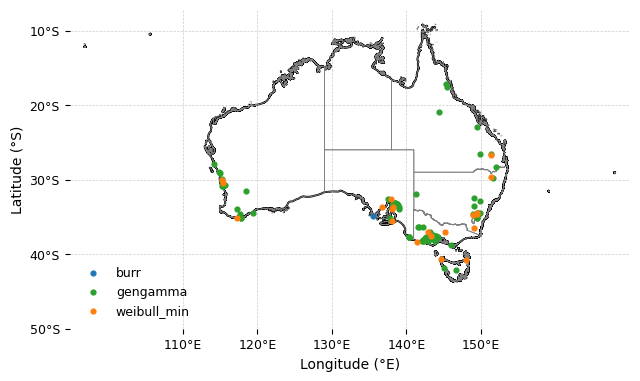

In [46]:
gdf_pts = gpd.GeoDataFrame(
    df_wind_distribution,
    geometry=gpd.points_from_xy(
        df_wind_distribution["lon"],
        df_wind_distribution["lat"],
    ),
    crs="EPSG:4326",
)

shp_states = r"../data/raw/shp/STE_2021_AUST_SHP_GDA2020/STE_2021_AUST_GDA2020.shp"
states = gpd.read_file(shp_states).to_crs("EPSG:4326")
aus_outline = states.dissolve()

color_map = {
    "burr": "#1f77b4",
    "weibull_min": "#ff7f0e",
    "gengamma": "#2ca02c",
}
fig, ax = plt.subplots(figsize=(6.5, 6))

aus_outline.boundary.plot(ax=ax, linewidth=1.4, color="black", zorder=1)
states.boundary.plot(ax=ax, linewidth=0.6, color="0.5", zorder=2, autolim=False)

for model, gdf_sub in gdf_pts.groupby("Model Name"):
    gdf_sub.plot(
        ax=ax,
        markersize=12,
        color=color_map.get(model, "black"),
        label=model,
        zorder=3,
    )

minx, miny, maxx, maxy = aus_outline.total_bounds
pad = 2.0
ax.set_xlim(minx - pad, maxx + pad)
ax.set_ylim(miny - pad, maxy + pad)

lon_ticks = np.arange(110, 160, 10)
lat_ticks = np.arange(-50, -5, 10)
ax.set_xticks(lon_ticks)
ax.set_yticks(lat_ticks)

def lon_formatter(x, pos):
    return f"{int(abs(x))}°E"

def lat_formatter(y, pos):
    return f"{int(abs(y))}°S"

ax.xaxis.set_major_formatter(FuncFormatter(lon_formatter))
ax.yaxis.set_major_formatter(FuncFormatter(lat_formatter))

ax.set_xlabel("Longitude (°E)", fontsize=10)
ax.set_ylabel("Latitude (°S)", fontsize=10)

ax.grid(
    True,
    which="major",
    linestyle="--",
    linewidth=0.5,
    color="0.8",
    zorder=0,
)

ax.tick_params(labelsize=9)
ax.set_aspect("equal", adjustable="box")

ax.legend(frameon=False, loc="lower left", fontsize=9)

for spine in ax.spines.values():
    spine.set_visible(False)
    
plt.tight_layout()
plt.savefig("../figures/wind_distribution_model.png", dpi=300, bbox_inches="tight")
plt.show()



# solar energy quantile  &  K-means clustering

In [64]:
with open("../data/processed/solar_ecdf_model.pkl", "rb") as f:
    ecdf_models = pickle.load(f)



In [ ]:
Q_LEVELS = [0.10, 0.25, 0.50, 0.75, 0.90]

def build_ecdf_quantile_features(ecdf_models: dict) -> pd.DataFrame:
    rows = []

    for site, model in ecdf_models.items():
        x = model.get("x_sorted", None)
        if x is None or len(x) == 0:
            continue

        x = np.asarray(x, dtype=float)

        qs = np.quantile(x, Q_LEVELS, method="linear")

        row = {"code": site}
        for q, v in zip(Q_LEVELS, qs):
            row[f"Q{int(q*100)}"] = float(v)

        rows.append(row)

    df = (
        pd.DataFrame(rows)
        .sort_index()
    )



In [67]:
df_solar_quantile = build_ecdf_quantile_features(ecdf_models)
df_solar_quantile


,code,Q10,Q25,Q50,Q75,Q90
0,0CULCSF,185.328125,287.000000,480.968750,712.921875,904.609375
1,0STUBBOSF,201.534375,308.972656,515.773438,737.566406,921.332813
2,ADP,183.140625,285.015625,469.664062,710.609375,915.023438
3,ALDGASF,205.953125,341.210938,553.164062,741.812500,898.485937
4,AMBRISOLAR,197.906250,326.742188,528.500000,765.242188,956.125000
...,...,...,...,...,...,...
106,WSTWYSF,197.390625,308.476562,504.296875,737.484375,923.206250
107,WUNUSF,181.421875,282.265625,470.609375,709.398438,907.171875
108,WYASF,197.390625,308.476562,504.296875,737.484375,923.206250
109,YARANSF,208.868750,329.671875,545.453125,747.132812,912.934375


In [ ]:

def kmeans_on_df_solar_quantile(
    df_solar_quantile: pd.DataFrame,
    k_min: int = 3,
    k_max: int = 6,
    random_state: int = 42
):
    feat_cols = [c for c in df_solar_quantile.columns if str(c).startswith("Q")]

    X = df_solar_quantile[feat_cols].to_numpy(dtype=float)
    Xs = StandardScaler().fit_transform(X)

    best = None
    for k in range(k_min, k_max + 1):
        km = KMeans(n_clusters=k, n_init=50, random_state=random_state)
        labels = km.fit_predict(Xs)
        score = silhouette_score(Xs, labels)
        if best is None or score > best["silhouette"]:
            best = {"k": k, "model": km, "labels": labels, "silhouette": score}

    df_solar_cluster = df_solar_quantile.copy()
    df_solar_cluster["cluster"] = best["labels"]

    return df_solar_cluster, best, feat_cols


In [73]:
df_solar_cluster, best_info, feat_cols = kmeans_on_df_solar_quantile(df_solar_quantile, 3, 6)
print("Best k =", best_info["k"], "Silhouette =", best_info["silhouette"])

df_solar_ecdf_plot = df_solar_cluster.merge(
    df_solar_site,
    on="code",
    how="inner"
)
cluster_map = {
    0: "Low",
    1: "Medium",
    2: "High",
}

df_solar_ecdf_plot["cluster_label"] = (
    df_solar_ecdf_plot["cluster"].map(cluster_map)
)

df_solar_ecdf_plot  

c:\Users\HKlll\.conda\envs\python\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\HKlll\.conda\envs\python\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\HKlll\.conda\envs\python\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\HKlll\.conda\envs\python\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is k

Best k = 3 Silhouette = 0.4308914785493522


,code,Q10,Q25,Q50,Q75,Q90,cluster,lat,lon,cluster_label
0,0CULCSF,185.328125,287.000000,480.968750,712.921875,904.609375,1,-35.75,147.00,Medium
1,0STUBBOSF,201.534375,308.972656,515.773438,737.566406,921.332813,2,-32.23,149.64,High
2,ADP,183.140625,285.015625,469.664062,710.609375,915.023438,1,-35.09,138.53,Medium
3,ALDGASF,205.953125,341.210938,553.164062,741.812500,898.485937,2,-23.87,151.07,High
4,AMBRISOLAR,197.906250,326.742188,528.500000,765.242188,956.125000,0,-32.12,115.76,Low
...,...,...,...,...,...,...,...,...,...,...
106,WSTWYSF,197.390625,308.476562,504.296875,737.484375,923.206250,1,-33.77,147.33,Medium
107,WUNUSF,181.421875,282.265625,470.609375,709.398438,907.171875,1,-36.19,145.35,Medium
108,WYASF,197.390625,308.476562,504.296875,737.484375,923.206250,1,-33.77,147.33,Medium
109,YARANSF,208.868750,329.671875,545.453125,747.132812,912.934375,2,-27.72,151.51,High


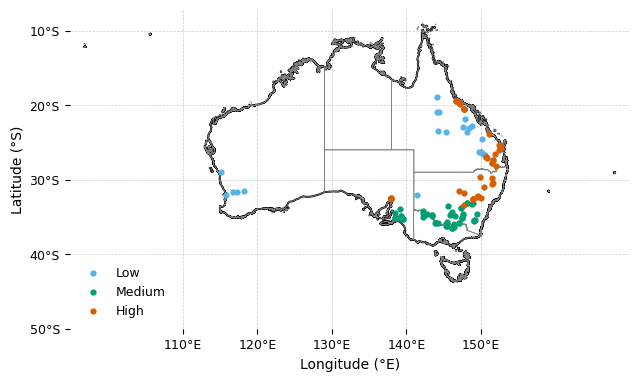

In [ ]:


gdf_pts = gpd.GeoDataFrame(
    df_solar_ecdf_plot.copy(),
    geometry=gpd.points_from_xy(
        df_solar_ecdf_plot["lon"],
        df_solar_ecdf_plot["lat"],
    ),
    crs="EPSG:4326",
)

shp_states = r"../data/raw/shp/STE_2021_AUST_SHP_GDA2020/STE_2021_AUST_GDA2020.shp"
states = gpd.read_file(shp_states).to_crs("EPSG:4326")
aus_outline = states.dissolve()

label_order = ["Low", "Medium", "High"]

color_map = {
    "Low": "#56B4E9",
    "Medium": "#009E73",
    "High": "#D55E00",
}

fig, ax = plt.subplots(figsize=(6.5, 6))

aus_outline.boundary.plot(ax=ax, linewidth=1.4, color="black", zorder=1)
states.boundary.plot(ax=ax, linewidth=0.6, color="0.5", zorder=2, autolim=False)

for lab in label_order:
    gdf_sub = gdf_pts[gdf_pts["cluster_label"] == lab]
    if len(gdf_sub) == 0:
        continue
    gdf_sub.plot(
        ax=ax,
        markersize=12,
        color=color_map.get(lab, "black"),
        label=lab,
        zorder=3,
    )

minx, miny, maxx, maxy = aus_outline.total_bounds
pad = 2.0
ax.set_xlim(minx - pad, maxx + pad)
ax.set_ylim(miny - pad, maxy + pad)

lon_ticks = np.arange(110, 160, 10)
lat_ticks = np.arange(-50, -5, 10)
ax.set_xticks(lon_ticks)
ax.set_yticks(lat_ticks)

def lon_formatter(x, pos):
    return f"{int(abs(x))}°E"

def lat_formatter(y, pos):
    return f"{int(abs(y))}°S"

ax.xaxis.set_major_formatter(FuncFormatter(lon_formatter))
ax.yaxis.set_major_formatter(FuncFormatter(lat_formatter))

ax.set_xlabel("Longitude (°E)", fontsize=10)
ax.set_ylabel("Latitude (°S)", fontsize=10)

ax.grid(True, which="major", linestyle="--", linewidth=0.5, color="0.8", zorder=0)

ax.tick_params(labelsize=9)
ax.set_aspect("equal", adjustable="box")
ax.legend(frameon=False, loc="lower left", fontsize=9)

for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.savefig("../figures/solar_ecdf_cluster_map.png", dpi=300, bbox_inches="tight")
plt.show()


In [129]:
df_drought_solar = pd.read_parquet("../data/curated/solar_drought_events.parquet")
df_drought_wind = pd.read_parquet("../data/curated/wind_drought_events.parquet")

In [130]:
df_drought_wind

,start_time,end_time,duration_hours,n_points,min_srepi,mean_srepi,threshold,site,window
0,2014-01-06 11:00:00,2014-01-06 14:00:00,3.0,4,-1.097019,-1.097019,-1.097019,0WAMBOWF,1h
1,2014-01-11 17:00:00,2014-01-11 23:00:00,6.0,7,-1.097019,-1.097019,-1.097019,0WAMBOWF,1h
2,2014-01-12 17:00:00,2014-01-12 20:00:00,3.0,4,-1.097019,-1.097019,-1.097019,0WAMBOWF,1h
3,2014-01-18 01:00:00,2014-01-18 03:00:00,2.0,3,-1.097019,-1.097019,-1.097019,0WAMBOWF,1h
4,2014-01-18 17:00:00,2014-01-19 01:00:00,8.0,9,-1.097019,-1.097019,-1.097019,0WAMBOWF,1h
...,...,...,...,...,...,...,...,...,...
464523,2023-07-25 17:00:00,2023-07-27 07:00:00,38.0,39,-1.734504,-1.528800,-1.280706,YSWF,120h
464524,2023-08-16 04:00:00,2023-08-16 23:00:00,19.0,20,-1.449346,-1.355444,-1.280706,YSWF,120h
464525,2023-10-10 07:00:00,2023-10-11 08:00:00,25.0,26,-1.658804,-1.505744,-1.280706,YSWF,120h
464526,2023-11-21 03:00:00,2023-11-22 07:00:00,28.0,29,-1.532508,-1.431066,-1.280706,YSWF,120h


In [132]:
WINDOWS = ["1h", "4h", "12h", "24h", "48h", "72h", "120h"]

df_drought_solar_plot = (
    df_drought_solar
    .groupby("window")["duration_hours"]
    .count()
    .reset_index(name="event_count")
)

df_drought_solar_plot

df_drought_solar_plot["window"] = pd.Categorical(
    df_drought_solar_plot["window"],
    categories=WINDOWS,
    ordered=True
)

df_drought_solar_plot = df_drought_solar_plot.sort_values("window")
df_drought_solar_plot



,window,event_count
2,1h,21875
5,4h,117101
1,12h,89742
3,24h,72195
4,48h,65312
6,72h,61706
0,120h,58640


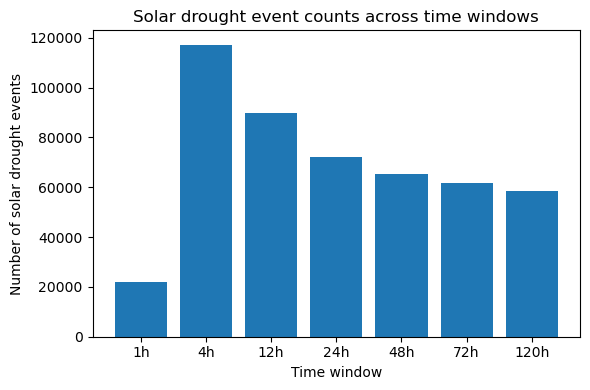

In [81]:

plt.figure(figsize=(6, 4))

plt.bar(
    df_drought_solar_plot["window"].astype(str),
    df_drought_solar_plot["event_count"]
)

plt.xlabel("Time window")
plt.ylabel("Number of solar drought events")
plt.title("Solar drought event counts across time windows")

plt.tight_layout()
plt.show()


In [85]:
df_drought_solar = df_drought_solar.merge(
    df_solar_site,
    on="code",
    how="inner"
)
df_drought_solar

,window,code,threshold,start_time,end_time,duration_hours,n_points,min_srepi,mean_srepi,lat,lon
0,120h,0CULCSF,-1.280352,2014-06-03 23:30:00,2014-06-04 05:30:00,7.0,7,-1.459466,-1.436642,-35.75,147.00
1,120h,0CULCSF,-1.280352,2014-06-04 23:30:00,2014-06-05 05:30:00,7.0,7,-1.518400,-1.506600,-35.75,147.00
2,120h,0CULCSF,-1.280352,2014-06-05 23:30:00,2014-06-06 05:30:00,7.0,7,-1.556063,-1.535677,-35.75,147.00
3,120h,0CULCSF,-1.280352,2014-06-06 22:30:00,2014-06-07 05:30:00,8.0,8,-1.593204,-1.555933,-35.75,147.00
4,120h,0CULCSF,-1.280352,2014-06-07 22:30:00,2014-06-08 05:30:00,8.0,8,-1.590348,-1.529420,-35.75,147.00
...,...,...,...,...,...,...,...,...,...,...,...
486566,72h,YATSF1,-1.280796,2023-07-08 23:30:00,2023-07-09 06:30:00,8.0,8,-2.912880,-2.270571,-34.43,142.16
486567,72h,YATSF1,-1.280796,2023-07-09 23:30:00,2023-07-10 05:30:00,7.0,7,-1.987290,-1.931042,-34.43,142.16
486568,72h,YATSF1,-1.280796,2023-07-10 23:30:00,2023-07-11 06:30:00,8.0,8,-1.851703,-1.648571,-34.43,142.16
486569,72h,YATSF1,-1.280796,2023-07-11 23:30:00,2023-07-12 06:30:00,8.0,8,-1.556792,-1.402962,-34.43,142.16


In [89]:
site_solar = pd.read_parquet("../data/raw/facilities/facilities_solar.parquet")

In [ ]:
df_drought_solar = df_drought_solar.merge(
    site_solar[["code", "network_region"]],
    on="code",
    how="inner"
)
df_drought_solar["state"] = df_drought_solar["network_region"].astype(str).str[:-1]
df_drought_solar = df_drought_solar.drop(columns=['network_region'])
df_drought_solar

,window,code,threshold,start_time,end_time,duration_hours,n_points,min_srepi,mean_srepi,lat,lon,state
0,120h,0CULCSF,-1.280352,2014-06-03 23:30:00,2014-06-04 05:30:00,7.0,7,-1.459466,-1.436642,-35.75,147.00,NSW
1,120h,0CULCSF,-1.280352,2014-06-04 23:30:00,2014-06-05 05:30:00,7.0,7,-1.518400,-1.506600,-35.75,147.00,NSW
2,120h,0CULCSF,-1.280352,2014-06-05 23:30:00,2014-06-06 05:30:00,7.0,7,-1.556063,-1.535677,-35.75,147.00,NSW
3,120h,0CULCSF,-1.280352,2014-06-06 22:30:00,2014-06-07 05:30:00,8.0,8,-1.593204,-1.555933,-35.75,147.00,NSW
4,120h,0CULCSF,-1.280352,2014-06-07 22:30:00,2014-06-08 05:30:00,8.0,8,-1.590348,-1.529420,-35.75,147.00,NSW
...,...,...,...,...,...,...,...,...,...,...,...,...
486566,72h,YATSF1,-1.280796,2023-07-08 23:30:00,2023-07-09 06:30:00,8.0,8,-2.912880,-2.270571,-34.43,142.16,VIC
486567,72h,YATSF1,-1.280796,2023-07-09 23:30:00,2023-07-10 05:30:00,7.0,7,-1.987290,-1.931042,-34.43,142.16,VIC
486568,72h,YATSF1,-1.280796,2023-07-10 23:30:00,2023-07-11 06:30:00,8.0,8,-1.851703,-1.648571,-34.43,142.16,VIC
486569,72h,YATSF1,-1.280796,2023-07-11 23:30:00,2023-07-12 06:30:00,8.0,8,-1.556792,-1.402962,-34.43,142.16,VIC


In [ ]:
WINDOWS = ["1h", "4h", "12h", "24h", "48h", "72h", "120h"]

df_plot_solar = df_drought_solar.copy()

df_plot_solar["start_time"] = pd.to_datetime(df_plot_solar["start_time"])
df_plot_solar["end_time"] = pd.to_datetime(df_plot_solar["end_time"])

df_plot_solar["window"] = pd.Categorical(df_plot_solar["window"], categories=WINDOWS, ordered=True)

df_plot_solar["year"] = df_plot_solar["start_time"].dt.year
df_plot_solar["month"] = df_plot_solar["start_time"].dt.to_period("M").astype(str)

C:\Users\HKlll\AppData\Local\Temp\ipykernel_2280\1535582922.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("window")["duration_hours"]


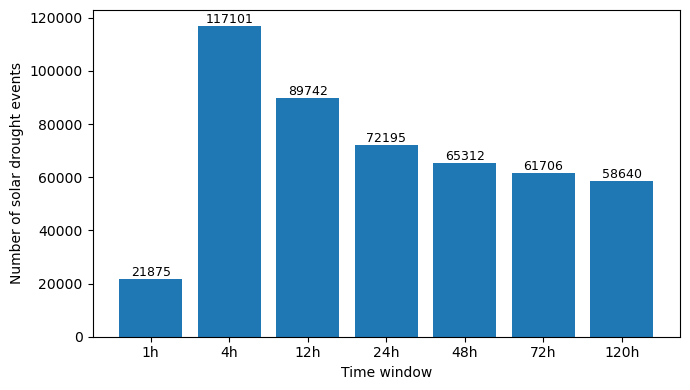

In [96]:
count_by_window = (
    df_plot_solar
    .groupby("window")["duration_hours"]
    .count()
    .reindex(WINDOWS)
)

plt.figure(figsize=(7,4))
bars = plt.bar(count_by_window.index.astype(str), count_by_window.values)

plt.xlabel("Time window")
plt.ylabel("Number of solar drought events")

for b in bars:
    h = b.get_height()
    plt.text(
        b.get_x() + b.get_width() / 2,
        h,
        f"{int(h)}",
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.tight_layout()
plt.savefig("fig_solar_count_by_window.png", dpi=300, bbox_inches="tight")
plt.show()


C:\Users\HKlll\AppData\Local\Temp\ipykernel_2280\619543637.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=WINDOWS, showfliers=False)


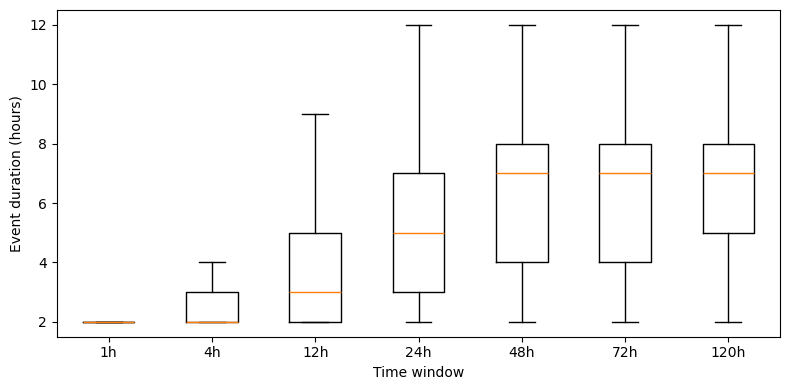

In [97]:
data = [
    df_plot_solar.loc[df_plot_solar["window"] == w, "duration_hours"]
    .dropna()
    .values
    for w in WINDOWS
]

plt.figure(figsize=(8,4))
plt.boxplot(data, labels=WINDOWS, showfliers=False)

plt.xlabel("Time window")
plt.ylabel("Event duration (hours)")

plt.tight_layout()
plt.savefig("fig_solar_duration_boxplot_by_window.png", dpi=300, bbox_inches="tight")
plt.show()


C:\Users\HKlll\AppData\Local\Temp\ipykernel_2280\2036868789.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["year", "window"])["duration_hours"]


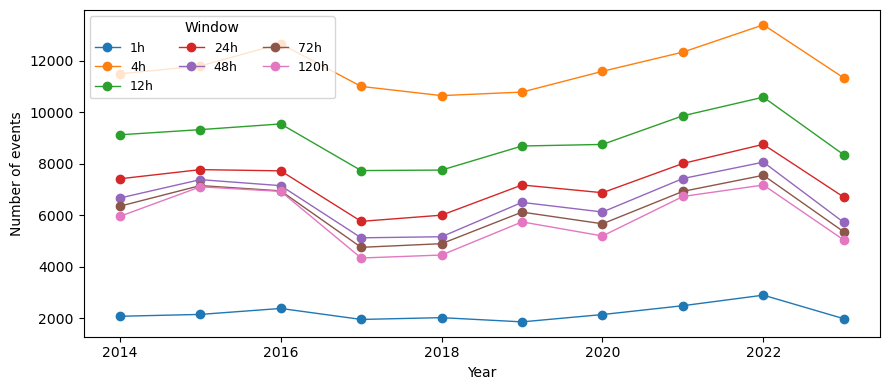

In [98]:
pivot_year = (
    df_plot_solar
    .groupby(["year", "window"])["duration_hours"]
    .count()
    .unstack("window")
    .reindex(columns=WINDOWS)
    .fillna(0)
    .sort_index()
)

plt.figure(figsize=(9,4))
for w in WINDOWS:
    if w in pivot_year.columns:
        plt.plot(
            pivot_year.index,
            pivot_year[w],
            marker="o",
            linewidth=1,
            label=w
        )

plt.xlabel("Year")
plt.ylabel("Number of events")
plt.legend(title="Window", ncol=3, fontsize=9)

plt.tight_layout()
plt.savefig("fig_solar_yearly_event_count_by_window.png", dpi=300, bbox_inches="tight")
plt.show()


C:\Users\HKlll\AppData\Local\Temp\ipykernel_2280\391593252.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["state", "window"])["duration_hours"]


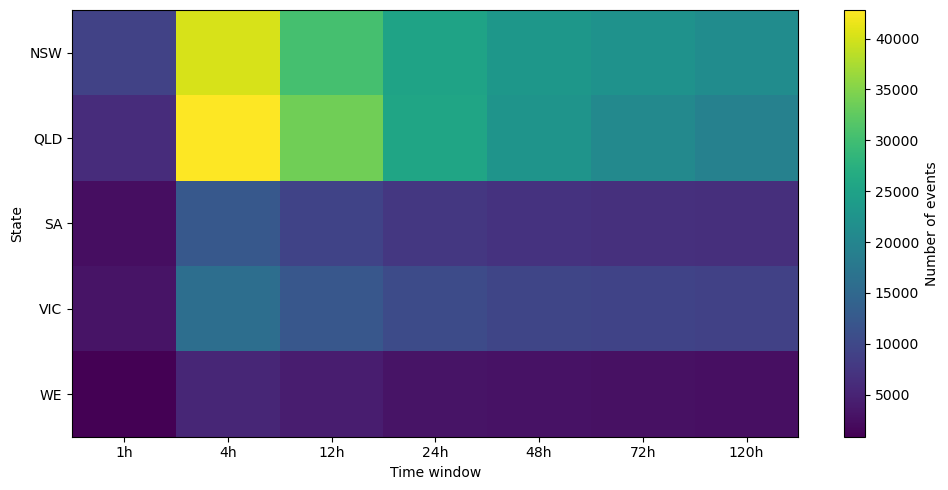

In [99]:
heat = (
    df_plot_solar
    .groupby(["state", "window"])["duration_hours"]
    .count()
    .unstack("window")
    .reindex(columns=WINDOWS)
    .fillna(0)
)

plt.figure(figsize=(10,5))
plt.imshow(heat.values, aspect="auto")

plt.xticks(range(len(heat.columns)), heat.columns.astype(str))
plt.yticks(range(len(heat.index)), heat.index.astype(str))

plt.xlabel("Time window")
plt.ylabel("State")

cbar = plt.colorbar()
cbar.set_label("Number of events")

plt.tight_layout()
plt.savefig("fig_solar_state_window_heatmap_count.png", dpi=300, bbox_inches="tight")
plt.show()


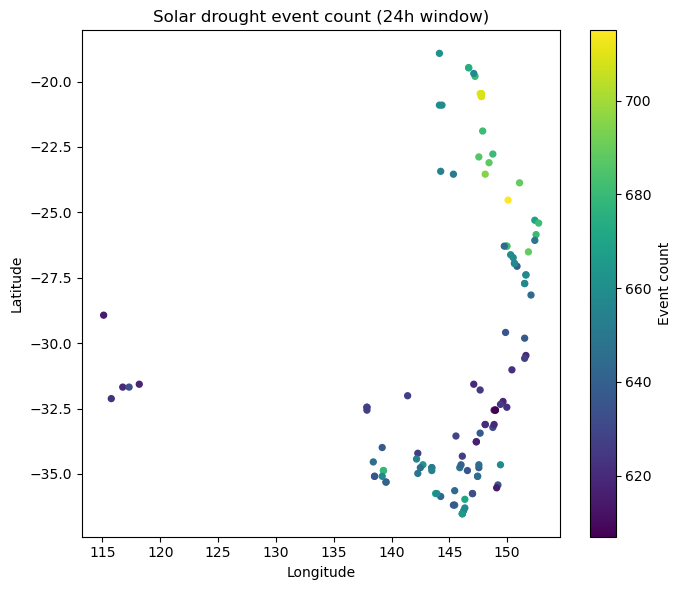

In [100]:
def site_summary_for_window(df_plot_solar, window):
    d = df_plot_solar[df_plot_solar["window"] == window]

    g = (
        d.groupby(["code", "lat", "lon", "state"])
        .agg(
            event_count=("duration_hours", "count"),
            mean_duration=("duration_hours", "mean"),
            min_of_min_srepi=("min_srepi", "min"),
            mean_srepi=("mean_srepi", "mean"),
        )
        .reset_index()
    )
    return g


g = site_summary_for_window(df_plot_solar, "24h")

plt.figure(figsize=(7,6))
sc = plt.scatter(
    g["lon"],
    g["lat"],
    c=g["event_count"],
    s=18
)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Solar drought event count (24h window)")

cbar = plt.colorbar(sc)
cbar.set_label("Event count")

plt.tight_layout()
plt.savefig("fig_solar_map_site_eventcount_24h.png", dpi=300, bbox_inches="tight")
plt.show()


C:\Users\HKlll\AppData\Local\Temp\ipykernel_2280\3894420307.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


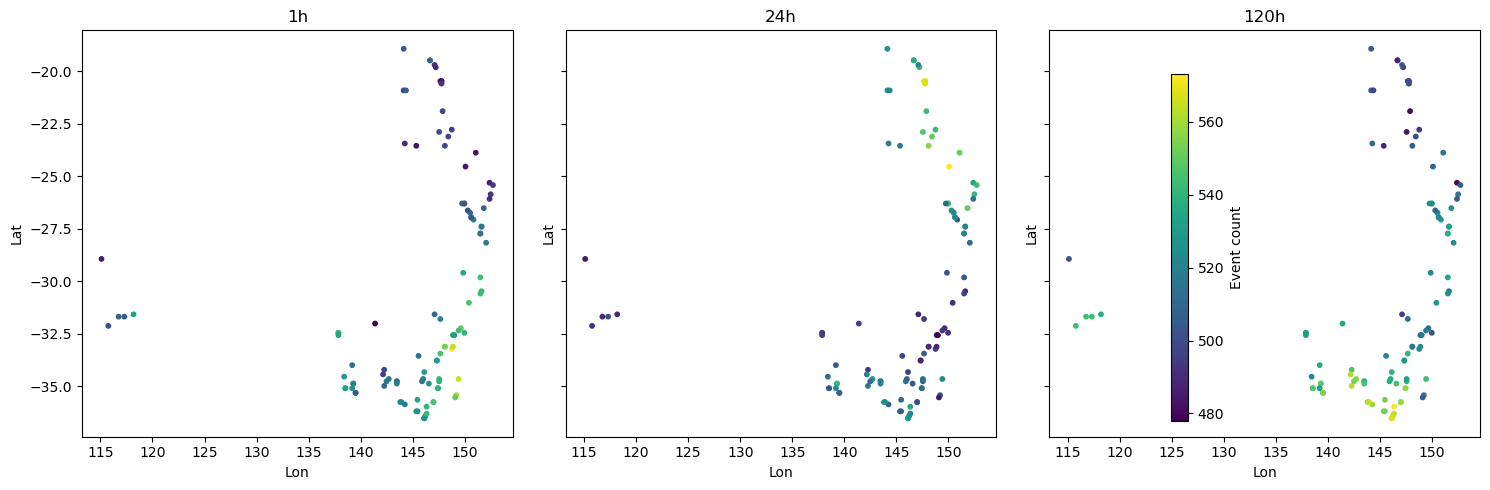

In [101]:
windows_to_plot = ["1h", "24h", "120h"]

fig, axes = plt.subplots(
    1, len(windows_to_plot),
    figsize=(15,5),
    sharex=True,
    sharey=True
)

for ax, w in zip(axes, windows_to_plot):
    g = site_summary_for_window(df_plot_solar, w)
    sc = ax.scatter(
        g["lon"],
        g["lat"],
        c=g["event_count"],
        s=10
    )
    ax.set_title(w)
    ax.set_xlabel("Lon")
    ax.set_ylabel("Lat")

fig.colorbar(
    sc,
    ax=axes.ravel().tolist(),
    label="Event count",
    shrink=0.9
)

fig.tight_layout()
fig.savefig("fig_solar_map_facets_eventcount.png", dpi=300, bbox_inches="tight")
plt.show()


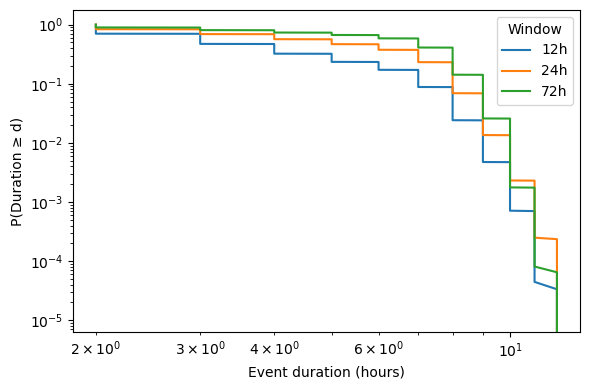

In [103]:
plt.figure(figsize=(6,4))

for w in ["12h", "24h", "72h"]:
    d = (
        df_plot_solar
        .loc[df_plot_solar["window"] == w, "duration_hours"]
        .dropna()
        .values
    )
    d = np.sort(d)
    ccdf = 1.0 - np.arange(1, len(d)+1) / len(d)
    plt.plot(d, ccdf, label=w)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Event duration (hours)")
plt.ylabel("P(Duration ≥ d)")
plt.legend(title="Window")

plt.tight_layout()
plt.savefig("fig_solar_duration_ccdf.png", dpi=300)
plt.show()


In [ ]:

df_plot_solar = df_plot_solar.copy()
df_plot_solar["start_time"] = pd.to_datetime(df_plot_solar["start_time"])

df_plot_solar["year"] = df_plot_solar["start_time"].dt.year
df_plot_solar["month_num"] = df_plot_solar["start_time"].dt.month

month_order = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
df_plot_solar["month"] = pd.Categorical(
    df_plot_solar["start_time"].dt.strftime("%b"),
    categories=month_order,
    ordered=True
)

def month_to_season_sh(m):
    if m in (12, 1, 2):  return "summer"  
    if m in (3, 4, 5):   return "autumn"  
    if m in (6, 7, 8):   return "winter"  
    return "spring"        

season_order = ["spring", "summer", "autumn", "winter"]
df_plot_solar["season"] = pd.Categorical(
    df_plot_solar["month_num"].map(month_to_season_sh),
    categories=season_order,
    ordered=True
)


In [107]:
df_plot_solar

,window,code,threshold,start_time,end_time,duration_hours,n_points,min_srepi,mean_srepi,lat,lon,state,year,month,window_h,month_num,season
0,120h,0CULCSF,-1.280352,2014-06-03 23:30:00,2014-06-04 05:30:00,7.0,7,-1.459466,-1.436642,-35.75,147.00,NSW,2014,Jun,120,6,winter
1,120h,0CULCSF,-1.280352,2014-06-04 23:30:00,2014-06-05 05:30:00,7.0,7,-1.518400,-1.506600,-35.75,147.00,NSW,2014,Jun,120,6,winter
2,120h,0CULCSF,-1.280352,2014-06-05 23:30:00,2014-06-06 05:30:00,7.0,7,-1.556063,-1.535677,-35.75,147.00,NSW,2014,Jun,120,6,winter
3,120h,0CULCSF,-1.280352,2014-06-06 22:30:00,2014-06-07 05:30:00,8.0,8,-1.593204,-1.555933,-35.75,147.00,NSW,2014,Jun,120,6,winter
4,120h,0CULCSF,-1.280352,2014-06-07 22:30:00,2014-06-08 05:30:00,8.0,8,-1.590348,-1.529420,-35.75,147.00,NSW,2014,Jun,120,6,winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486566,72h,YATSF1,-1.280796,2023-07-08 23:30:00,2023-07-09 06:30:00,8.0,8,-2.912880,-2.270571,-34.43,142.16,VIC,2023,Jul,72,7,winter
486567,72h,YATSF1,-1.280796,2023-07-09 23:30:00,2023-07-10 05:30:00,7.0,7,-1.987290,-1.931042,-34.43,142.16,VIC,2023,Jul,72,7,winter
486568,72h,YATSF1,-1.280796,2023-07-10 23:30:00,2023-07-11 06:30:00,8.0,8,-1.851703,-1.648571,-34.43,142.16,VIC,2023,Jul,72,7,winter
486569,72h,YATSF1,-1.280796,2023-07-11 23:30:00,2023-07-12 06:30:00,8.0,8,-1.556792,-1.402962,-34.43,142.16,VIC,2023,Jul,72,7,winter


In [108]:
dfw = df_plot_solar.copy()


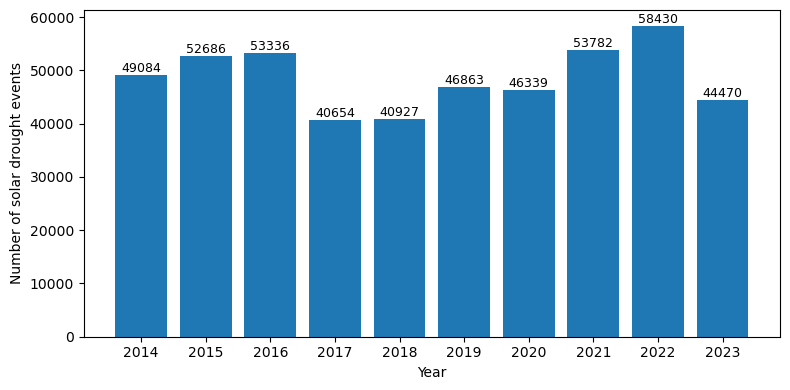

In [ ]:
year_counts = (
    dfw.groupby("year")["duration_hours"]
    .count()
)

fig, ax = plt.subplots(figsize=(8, 4))

bars = ax.bar(
    year_counts.index.astype(str),
    year_counts.values,
)

ax.set_xlabel("Year")
ax.set_ylabel("Number of solar drought events")
ax.set_xticks(range(len(year_counts)))
ax.set_xticklabels(year_counts.index.astype(str), rotation=0)

for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        height,
        ha="center",
        va="bottom",
        fontsize=9,
    )

plt.tight_layout()
plt.savefig(
    "../figures/fig_solar_by_year.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()


C:\Users\HKlll\AppData\Local\Temp\ipykernel_2280\981583459.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfw.groupby("season")["duration_hours"]
C:\Users\HKlll\AppData\Local\Temp\ipykernel_2280\981583459.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfw.groupby("season")["duration_hours"]


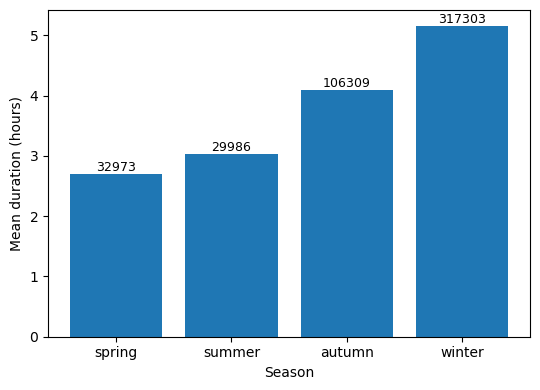

In [ ]:
season_mean_dur = (
    dfw.groupby("season")["duration_hours"]
    .mean()
    .reindex(season_order)
)

season_count = (
    dfw.groupby("season")["duration_hours"]
    .count()
    .reindex(season_order)
)

fig, ax = plt.subplots(figsize=(5.5, 4))

bars = ax.bar(
    season_mean_dur.index.astype(str),
    season_mean_dur.values,
)

ax.set_xlabel("Season")
ax.set_ylabel("Mean duration (hours)")

for bar, n in zip(bars, season_count.values):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        n,
        ha="center",
        va="bottom",
        fontsize=9,
    )

plt.tight_layout()
plt.savefig(
    "../figures/fig_solar_by_season.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()


C:\Users\HKlll\AppData\Local\Temp\ipykernel_2280\2013039180.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfw.groupby("month")["duration_hours"]
C:\Users\HKlll\AppData\Local\Temp\ipykernel_2280\2013039180.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfw.groupby("month")["duration_hours"]


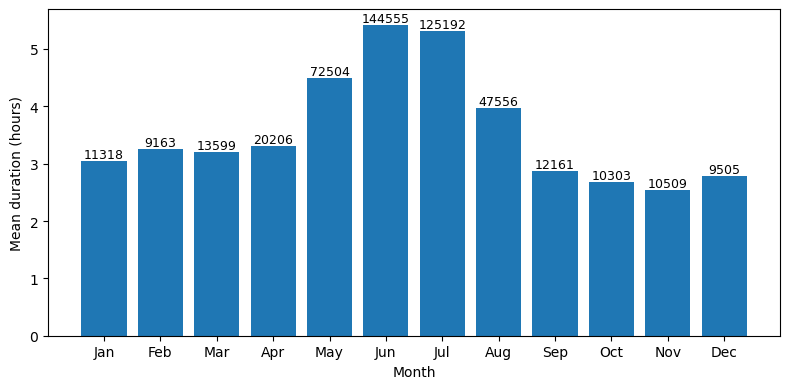

In [ ]:
month_mean_dur = (
    dfw.groupby("month")["duration_hours"]
    .mean()
    .reindex(month_order)
)

month_count = (
    dfw.groupby("month")["duration_hours"]
    .count()
    .reindex(month_order)
)

fig, ax = plt.subplots(figsize=(8, 4))

bars = ax.bar(
    month_mean_dur.index.astype(str),
    month_mean_dur.values,
)

ax.set_xlabel("Month")
ax.set_ylabel("Mean duration (hours)")

for bar, n in zip(bars, month_count.values):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        n,
        ha="center",
        va="bottom",
        fontsize=9,
        rotation=0,
    )

plt.tight_layout()
plt.savefig("../figures/fig_solar_by_month.png", dpi=300, bbox_inches="tight")
plt.show()


# comparison

In [ ]:
WINDOWS = ["1h", "4h", "12h", "24h", "48h", "72h", "120h"]

df_plot_solar = df_drought_solar.copy()
df_plot_wind  = df_drought_wind.copy()

df_plot_solar["source"] = "Solar"
df_plot_wind["source"]  = "Wind"

df_plot_all = pd.concat([df_plot_solar, df_plot_wind], ignore_index=True)

df_plot_all["start_time"] = pd.to_datetime(df_plot_all["start_time"])
df_plot_all["end_time"]   = pd.to_datetime(df_plot_all["end_time"])

df_plot_all["window"] = pd.Categorical(
    df_plot_all["window"],
    categories=WINDOWS,
    ordered=True
)

df_plot_all["year"]  = df_plot_all["start_time"].dt.year
df_plot_all["month"] = df_plot_all["start_time"].dt.to_period("M").astype(str)


In [ ]:
count_by_window_source = (
    df_plot_all
    .groupby(["window", "source"])["duration_hours"]
    .count()
    .unstack("source")     
    .reindex(WINDOWS)
    .fillna(0)
)


C:\Users\HKlll\AppData\Local\Temp\ipykernel_2280\1247508598.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["window", "source"])["duration_hours"]


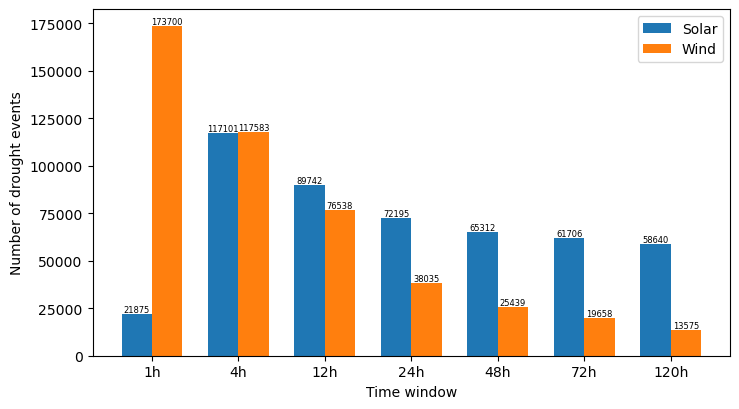

In [ ]:
x = np.arange(len(WINDOWS))
width = 0.35

plt.figure(figsize=(7.5, 4.2))

bars1 = plt.bar(x - width/2, count_by_window_source["Solar"], width, label="Solar")
bars2 = plt.bar(x + width/2, count_by_window_source["Wind"],  width, label="Wind")

plt.xticks(x, WINDOWS)
plt.xlabel("Time window")
plt.ylabel("Number of drought events")
plt.legend()

for bars in [bars1, bars2]:
    for b in bars:
        h = b.get_height()
        plt.text(
            b.get_x() + b.get_width()/2,
            h,
            f"{int(h)}",
            ha="center",
            va="bottom",
            fontsize=6
        )

plt.tight_layout()
plt.savefig("../figures/fig_sw_by_window.png", dpi=300, bbox_inches="tight")
plt.show()


In [143]:
df_plot_all["month_num"] = df_plot_all["start_time"].dt.month
MONTH_ORDER = list(range(1, 13))
MONTH_LABELS = ["Jan","Feb","Mar","Apr","May","Jun",
                "Jul","Aug","Sep","Oct","Nov","Dec"]
count_by_month_source = (
    df_plot_all
    .groupby(["month_num", "source"])["duration_hours"]
    .count()
    .unstack("source")
    .reindex(MONTH_ORDER)
    .fillna(0)
)


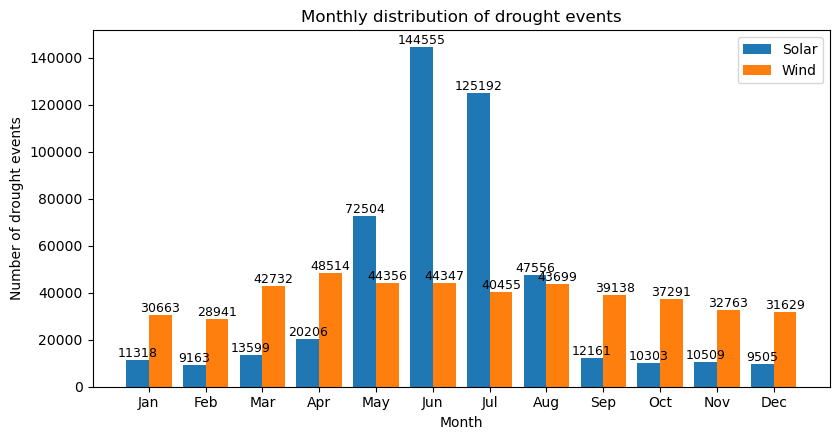

In [ ]:
x = np.arange(12)
width = 0.40

plt.figure(figsize=(8.5, 4.5))

bars1 = plt.bar(
    x - width/2,
    count_by_month_source["Solar"],
    width,
    label="Solar"
)
bars2 = plt.bar(
    x + width/2,
    count_by_month_source["Wind"],
    width,
    label="Wind"
)

plt.xticks(x, MONTH_LABELS)
plt.xlabel("Month")
plt.ylabel("Number of drought events")
plt.title("Monthly distribution of drought events")
plt.legend()

for bars in [bars1, bars2]:
    for b in bars:
        h = b.get_height()
        plt.text(
            b.get_x() + b.get_width()/2,
            h,
            f"{int(h)}",
            ha="center",
            va="bottom",
            fontsize=9
        )

plt.tight_layout()
plt.savefig(
    "../figures/fig_sw_by_month.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()


In [147]:
def month_to_season_southern(month: int) -> str:
    if month in [12, 1, 2]:
        return "Summer"   # Summer
    elif month in [3, 4, 5]:
        return "Autumn"   # Autumn
    elif month in [6, 7, 8]:
        return "Winter"   # Winter
    else:
        return "Spring"   # Spring

df_plot_all["season"] = df_plot_all["start_time"].dt.month.map(month_to_season_southern)

SEASON_ORDER = ["Spring", "Summer", "Autumn", "Winter"]
count_by_season_source = (
    df_plot_all
    .groupby(["season", "source"])["duration_hours"]
    .count()
    .unstack("source")
    .reindex(SEASON_ORDER)
    .fillna(0)
)


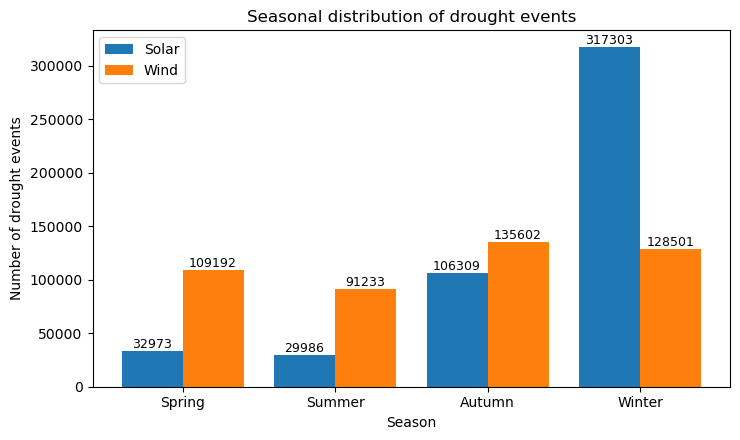

In [ ]:
x = np.arange(len(SEASON_ORDER))
width = 0.40

plt.figure(figsize=(7.5, 4.5))

bars1 = plt.bar(
    x - width/2,
    count_by_season_source["Solar"],
    width,
    label="Solar"
)
bars2 = plt.bar(
    x + width/2,
    count_by_season_source["Wind"],
    width,
    label="Wind"
)

plt.xticks(x, SEASON_ORDER)
plt.xlabel("Season")
plt.ylabel("Number of drought events")
plt.title("Seasonal distribution of drought events")
plt.legend()

for bars in [bars1, bars2]:
    for b in bars:
        h = b.get_height()
        plt.text(
            b.get_x() + b.get_width()/2,
            h,
            f"{int(h)}",
            ha="center",
            va="bottom",
            fontsize=9
        )

plt.tight_layout()
plt.savefig(
    "../figures/fig_sw_by_season.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()


In [149]:
df_plot_all["year"] = df_plot_all["start_time"].dt.year
count_by_year_source = (
    df_plot_all
    .groupby(["year", "source"])["duration_hours"]
    .count()
    .unstack("source")
    .fillna(0)
    .sort_index()
)


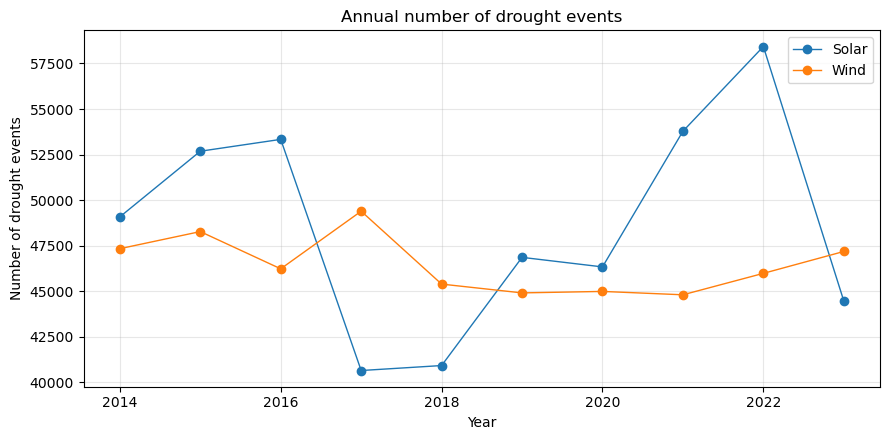

In [150]:
plt.figure(figsize=(9, 4.5))

plt.plot(
    count_by_year_source.index,
    count_by_year_source["Solar"],
    marker="o",
    linewidth=1,
    label="Solar"
)
plt.plot(
    count_by_year_source.index,
    count_by_year_source["Wind"],
    marker="o",
    linewidth=1,
    label="Wind"
)

plt.xlabel("Year")
plt.ylabel("Number of drought events")
plt.title("Annual number of drought events")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(
    "../figures/fig_sw_by_year.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()
